In [11]:
import squigglepy as sq
import numpy as np

from pprint import pprint

from datetime import datetime
from libs import plot_exponential_growth, fmt_worktime
from params import doubling_time, acceleration

GPT5_LAUNCH_DATE = datetime(2025, 8, 7)
O3_LAUNCH_DATE = datetime(2025, 4, 16)
CLAUDE_3P7_LAUNCH_DATE = datetime(2025, 2, 24)

print('Loaded libraries')

Loaded libraries


In [12]:
# Generate quarterly METR predictions (PUBLIC MODELS - NO SHIFT)
print("METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS")
print("=" * 70)
print(f"Baseline: GPT5 at 2.28hr on {O3_LAUNCH_DATE.strftime('%Y-%m-%d')}")
print("=" * 70)
print()

# Define quarters to predict (END of quarter)
def end_of_quarter(year, q):
    if q == 1:
        return datetime(year, 3, 31)
    elif q == 2:
        return datetime(year, 6, 30)
    elif q == 3:
        return datetime(year, 9, 30)
    else:  # q == 4
        return datetime(year, 12, 31)

quarters = []
# Start with Q3 2025 since GPT5 launched in August
for year in range(2025, 2030):
    start_q = 3 if year == 2025 else 1
    for q in range(start_q, 5):
        quarters.append((year, q, end_of_quarter(year, q)))

# Sample parameters
n_samples = 50000
tau_samples = sq.sample(doubling_time, n=n_samples)
accel_samples = sq.sample(acceleration, n=n_samples)

print(f"{'Quarter':<8} {'End Date':<12} {'Mean':<10} {'Median':<10} {'90% CI':<25} {'Days'}")
print("-" * 85)

results = []
for year, q, quarter_date in quarters:
    days_from_gpt5 = (quarter_date - GPT5_LAUNCH_DATE).days
    
    if days_from_gpt5 < 0:
        continue
    
    # Use the calculate_doubling_time function logic
    task_lengths = np.zeros(n_samples)
    for i in range(n_samples):
        if accel_samples[i] == 1:
            # Simple exponential
            doublings = days_from_gpt5 / tau_samples[i]
            task_lengths[i] = 2.28 * (2 ** doublings)
        else:
            # Superexponential - use binary search
            low, high = 0, 100
            tau0 = tau_samples[i]
            a = accel_samples[i]
            
            for _ in range(50):
                mid = (low + high) / 2
                predicted_days = tau0 * (1 - a**mid) / (1 - a) if a != 1 and a > 0 and not np.isnan(a) else mid * tau0
                
                if predicted_days < days_from_gpt5:
                    low = mid
                else:
                    high = mid
            
            doublings = (low + high) / 2
            task_lengths[i] = 1.75 * (2 ** doublings)
    
    # Cap at reasonable maximum
    task_lengths = np.minimum(task_lengths, 2000)
    
    # Calculate statistics
    mean_val = np.mean(task_lengths)
    median_val = np.median(task_lengths)
    p5 = np.percentile(task_lengths, 5)
    p95 = np.percentile(task_lengths, 95)
    
    ci_str = f"[{fmt_worktime(p5)} - {fmt_worktime(p95)}]"
    date_str = quarter_date.strftime("%Y-%m-%d")
    
    print(f"{year}Q{q:<7} {date_str:<12} {fmt_worktime(mean_val):<10} {fmt_worktime(median_val):<10} {ci_str:<25} {days_from_o3:>4}")
    
    results.append({
        'quarter': f"{year}Q{q}",
        'date': quarter_date,
        'mean': mean_val,
        'median': median_val,
        'p5': p5,
        'p95': p95,
        'days': days_from_o3,
        'task_lengths': task_lengths
    })
    
    if q == 4:
        print()

# Show key milestones
print("\n" + "=" * 70)
print("Key Milestones (Median Estimates) - PUBLIC MODELS")
print("=" * 70)

# Updated milestones using work time
milestones = [(2, "2 hours"), (4, "4 hours"), (8, "1 day"), 
              (16, "2 days"), (24, "3 days"), (40, "1 week"), (174, "1 month")]

for hours, name in milestones:
    for r in results:
        if r['median'] >= hours:
            prob = np.mean(r['task_lengths'] >= hours) * 100
            date_str = r['date'].strftime("%B %d, %Y")
            print(f"{name:<12} → {r['quarter']} ({date_str}, {prob:.0f}% of samples)")
            break
    else:
        print(f"{name:<12} → Not reached by 2029Q4")

METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS
Baseline: GPT5 at 2.28hr on 2025-04-16

Quarter  End Date     Mean       Median     90% CI                    Days
-------------------------------------------------------------------------------------
2025Q3       2025-09-30   2.7hr      2.7hr      [2.1hr - 3.1hr]           1720
2025Q4       2025-12-31   4.2hr      3.8hr      [2.8hr - 5.4hr]           1720

2026Q1       2026-03-31   6.6hr      5.2hr      [3.8hr - 1.1d]            1720
2026Q2       2026-06-30   1.3d       7.4hr      [5.0hr - 1.9d]            1720
2026Q3       2026-09-30   2.1d       1.3d       [6.6hr - 3.3d]            1720
2026Q4       2026-12-31   3.5d       1.8d       [1.1d - 1.2wk]            1720

2027Q1       2027-03-31   1.1wk      2.6d       [1.4d - 2.0wk]            1720
2027Q2       2027-06-30   1.8wk      3.6d       [1.7d - 3.6wk]            1720
2027Q3       2027-09-30   2.9wk      1.0wk      [2.2d - 6.6wk]            1720
2027Q4       2027-12-3

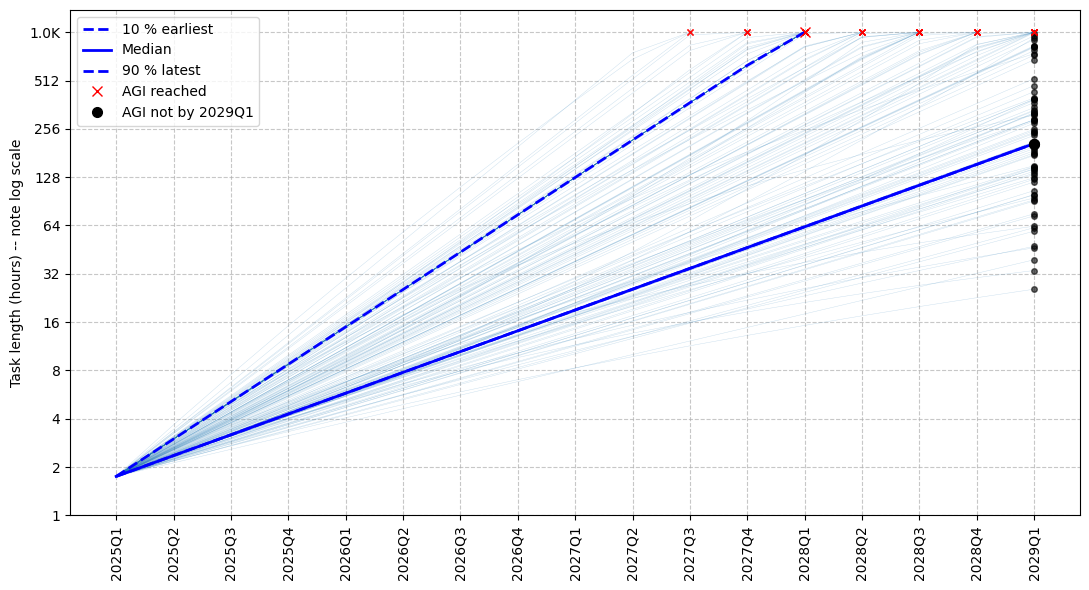

In [13]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    starting_hours=1.75,
    agi_task_length=100_000,
    shift=0,
    acceleration=acceleration,
    n_quarters=16,
    n_samples=100_000,
    n_traces=200,
    max_task_power=10,
)

In [14]:
print("PREDICT CLAUDE 4")

claude_4_launch_date = datetime(2025, 5, 22)
days_since_o3 = (claude_4_launch_date - O3_LAUNCH_DATE).days

def model():
    doublings = days_since_o3 / doubling_time
    effective_doublings = doublings ** acceleration
    return 1.75 * (2 ** effective_doublings)

print("Model predictions for Claude 4")
mean_ci = sq.get_mean_and_ci(sq.sample(model, n=50_000))
print(f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")
print('Actual observed: Claude 4 Opus at ~1.1-1.3 hours')

PREDICT CLAUDE 4
Model predictions for Claude 4
Predicted: 2.0hr (1.9hr - 2.2hr)
Actual observed: Claude 4 Opus at ~1.1-1.3 hours


In [16]:
print("PREDICT GPT5")

gpt5_launch_date = datetime(2025, 8, 7)
days_since_o3 = (gpt5_launch_date - O3_LAUNCH_DATE).days

def model():
    doublings = days_since_o3 / doubling_time
    effective_doublings = doublings ** acceleration
    return 1.75 * (2 ** effective_doublings)

print("Model predictions for GPT5")
mean_ci = sq.get_mean_and_ci(sq.sample(model, n=50_000))
print(f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")
print('Actual observed: GPT5 at ~2.28hrs (1-4.5hrs)')

PREDICT GPT5
Model predictions for GPT5
Predicted: 2.9hr (2.4hr - 3.4hr)
Actual observed: GPT5 at ~2.28hrs (1-4.5hrs)


In [17]:
print("Sanity Check - Current State")

today = datetime(2025, 8, 9)
days_since_gpt5 = (today - GPT5_LAUNCH_DATE).days
print('')
print(f"Days since GPT5: {days_since_gpt5}")
print('')
print(f"Model predictions for PUBLIC models on {today.date()}")

def model():
    doublings = days_since_gpt5 / doubling_time
    effective_doublings = doublings ** acceleration
    return 2.28 * (2 ** effective_doublings)

mean_ci = sq.get_mean_and_ci(sq.sample(model, n=50_000))
print(f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")
print('Actual observed: GPT5 at ~2.28hrs (1-4.5hrs)')

Sanity Check - Current State

Days since GPT5: 2

Model predictions for PUBLIC models on 2025-08-09
Predicted: 2.4hr (2.3hr - 2.3hr)
Actual observed: GPT5 at ~2.28hrs (1-4.5hrs)
